<h1>Section 1: Main Role Classification</h1>

<h3>Imports</h3>

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

<h3>Step 1: Load Annotations and Extract Context</h3>

In [2]:
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            article_id = parts[0]
            entity = parts[1]
            start_offset = int(parts[2])
            end_offset = int(parts[3])
            main_role = parts[4]
            fine_grained_roles = parts[5:]
            annotations.append({
                'article_id': article_id,
                'entity': entity,
                'start_offset': start_offset,
                'end_offset': end_offset,
                'main_role': main_role,
                'fine_grained_roles': fine_grained_roles
            })
    return pd.DataFrame(annotations)

# Load article text
def load_article_text(article_path):
    with open(article_path, 'r', encoding='utf-8') as f:
        return f.read()

# Extract a window of characters around the entity
def extract_context_window(article_text, start, end, window_size=250):
    start_idx = max(0, start - window_size)
    end_idx = min(len(article_text), end + window_size)
    return article_text[start_idx:end_idx]


<h3>Step 1.5: Define a Preprocessing Function</h3>

In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize and remove stopwords
    words = text.split()

    # Rejoin words to form the processed text
    return " ".join(words)


<h3>Step 2: Prepare Context Data for TF-IDF</h3>

In [4]:

import gensim
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(contexts):
    tokenized_contexts = [text.split() for text in contexts]
    word2vec_model = Word2Vec(sentences=tokenized_contexts, vector_size=300, window=5, min_count=1, sg=1)
    return word2vec_model

# Compute Word2Vec embeddings for each context
def compute_word2vec_features(word2vec_model, contexts):
    embeddings = []
    for text in contexts:
        words = text.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]

        # If there are no words in the Word2Vec vocabulary, use zero vector
        if len(word_vectors) > 0:
            mean_embedding = np.mean(word_vectors, axis=0)
        else:
            mean_embedding = np.zeros(word2vec_model.vector_size)

        embeddings.append(mean_embedding)

    return pd.DataFrame(embeddings)

# Updated feature engineering function to integrate Word2Vec
def add_context_tfidf_word2vec(annotations_df, raw_docs_folder, window_size=250):
    contexts = []
    for idx, row in annotations_df.iterrows():
        article_id = row['article_id']
        article_path = os.path.join(raw_docs_folder, article_id)
        article_text = load_article_text(article_path)

        # Extract context window
        context_text = extract_context_window(article_text, row['start_offset'], row['end_offset'], window_size)

        # Preprocess context text
        processed_context = preprocess_text(context_text)
        contexts.append(processed_context)

    # TF-IDF feature extraction
    tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(1, 5), max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(contexts)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Train Word2Vec on the processed contexts
    word2vec_model = train_word2vec(contexts)
    word2vec_df = compute_word2vec_features(word2vec_model, contexts)

    # Combine TF-IDF and Word2Vec features
    combined_features_df = pd.concat([annotations_df.reset_index(drop=True), tfidf_df, word2vec_df], axis=1)
    return combined_features_df

# Paths to the raw documents and annotations
raw_docs_folder = "EN/raw-documents"
annotation_file = "EN/subtask-1-annotations.txt"

# Load annotations and create TF-IDF features
annotations_df = load_annotations(annotation_file)
annotations_with_features = add_context_tfidf_word2vec(annotations_df, raw_docs_folder)


<h3>Step 3: Prepare Features and Target</h3>

In [5]:
from imblearn.over_sampling import SMOTE
# Prepare Features (X) and Target (y)
X = annotations_with_features.iloc[:, 6:]  # TF-IDF features only
X.columns = X.columns.astype(str)  # Ensure all column names are strings
y = annotations_with_features['main_role']

# Encode the main_role labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=40)

# Apply SMOTE to balance classes in the training data
smote = SMOTE(random_state=40)
X_train, y_train = smote.fit_resample(X_train, y_train)

<h3>Step 4: Define and Train the Models</h3>

Model 1: Random Forest

In [6]:
# Updated Random Forest classifier
rf_classifier = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=500,              # Increased from 500 to 1000
        max_depth=6,                   # Experiment with depths between 10 and 20
        criterion='log_loss',
        min_samples_split=3,
        min_samples_leaf=3,             # Ensures each leaf has enough data
        # max_features=0.5,               # Reduce correlation among trees
        class_weight='balanced',        # Keeps existing balanced setting
        min_impurity_decrease=0.01,    # Regularization parameter to prevent overfitting
        bootstrap=True,
        max_leaf_nodes=50,             # Limit the number of nodes for each tree
        random_state=40                 # Keep a fixed seed for reproducibility
    )
)

# Train the model
rf_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     criterion='log_loss',
                                                     max_depth=6,
                                                     max_leaf_nodes=50,
                                                     min_impurity_decrease=0.01,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     n_estimators=500,
                                                     random_state=40))

Model 2: Support Vector Machine (SVM) with OneVsRest

In [7]:
# Updated SVM classifier
svm_classifier = OneVsRestClassifier(
    SVC(
        kernel='linear',               # Other options: 'linear', 'poly'
        C=20,                       # Regularization parameter, experiment with 0.1, 1, 10, 100
        gamma=0.1,              # Kernel coefficient, 'scale' or 'auto', or specific values like 0.1
        probability=True,           # Enable probability estimates for more flexible evaluation
        class_weight='balanced',    # Important for imbalanced datasets
        tol=0.00001,                 # Lower tolerance for stopping criterion
        max_iter=5000,              # Set a max iteration limit to avoid excessive runtime
        random_state=40             # Ensure reproducibility
    )
)

# Train the model
svm_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


OneVsRestClassifier(estimator=SVC(C=20, class_weight='balanced', gamma=0.1,
                                  kernel='linear', max_iter=5000,
                                  probability=True, random_state=40,
                                  tol=1e-05))

Model 3: XGBoost

In [8]:
from xgboost import XGBClassifier

# Define the model
xgb_classifier = OneVsRestClassifier(
    XGBClassifier(
        objective='multi:softprob',
        num_class=3,  # Update to the number of classes
        eval_metric='mlogloss',
        booster='gbtree',
        eta=0.1,
        gamma=1,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.8,
        alpha=0.5,
        max_delta_step=1,
        n_estimators=300,
        # scale_pos_weight=2,  # Adjust based on class imbalance
        tree_method='hist',
        verbosity=1,
        random_state=40
    )
)

# Train the model
xgb_classifier.fit(X_train, y_train)


OneVsRestClassifier(estimator=XGBClassifier(alpha=0.5, base_score=None,
                                            booster='gbtree', callbacks=None,
                                            colsample_bylevel=0.8,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.1,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=1, max_depth=6,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None, ...))

Model 4: Logistic Regression (One-vs-Rest or Softmax)

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg_classifier = LogisticRegression(
    C=10,
    solver='newton-cg',
    max_iter=1000,
    multi_class='ovr',  # or 'ovr' for one-vs-rest
    random_state=40
)
log_reg_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, max_iter=1000, multi_class='ovr', random_state=40,
                   solver='newton-cg')

Model 5: Neural Networks (Multi-layer Perceptrons)

In [10]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(512, 1024, 512),
    activation='relu',
    solver='adam',
    max_iter=5000,
    random_state=40
)
mlp_classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(512, 1024, 512), max_iter=5000,
              random_state=40)

Model 6: Extra Trees (Extremely Randomized Trees)

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_classifier = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='log_loss',
    min_samples_split=3,
    random_state=40
)
extra_trees_classifier.fit(X_train, y_train)

ExtraTreesClassifier(criterion='log_loss', max_depth=8, min_samples_split=3,
                     n_estimators=500, random_state=40)

Model 7: Multinomial Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

multi_log_reg_classifier = LogisticRegression(
    C=20,
    solver='saga',
    multi_class='multinomial',
    max_iter=2000,
    random_state=40
)
multi_log_reg_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=20, max_iter=2000, multi_class='multinomial',
                   random_state=40, solver='saga')

<h3>Step 5: Evaluate the Models</h3>

In [13]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Decode predictions for interpretation
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_test_decoded = label_encoder.inverse_transform(y_test)

    # Print metrics
    print(f"Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
    print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_decoded, y_pred_decoded))

    print("---------------------------------------------------")
    print("---------------------------------------------------")

# Evaluate both models
evaluate_model(rf_classifier, X_test, y_test, "Random Forest")
evaluate_model(svm_classifier, X_test, y_test, "SVM")
evaluate_model(xgb_classifier, X_test, y_test, "XGBoost")
evaluate_model(log_reg_classifier, X_test, y_test, "Logistic Regression")
evaluate_model(mlp_classifier, X_test, y_test, "Neural Network")
evaluate_model(extra_trees_classifier, X_test, y_test, "Extra Trees")
evaluate_model(multi_log_reg_classifier, X_test, y_test, "Multinomial Logistic Regression")

Results for Random Forest
Accuracy: 0.7028985507246377

Classification Report:
               precision    recall  f1-score   support

  Antagonist       0.73      0.94      0.82        94
    Innocent       0.00      0.00      0.00        16
 Protagonist       0.60      0.32      0.42        28

    accuracy                           0.70       138
   macro avg       0.44      0.42      0.41       138
weighted avg       0.62      0.70      0.65       138


Confusion Matrix:
 [[88  2  4]
 [14  0  2]
 [18  1  9]]
---------------------------------------------------
---------------------------------------------------
Results for SVM
Accuracy: 0.6739130434782609

Classification Report:
               precision    recall  f1-score   support

  Antagonist       0.79      0.81      0.80        94
    Innocent       0.20      0.19      0.19        16
 Protagonist       0.52      0.50      0.51        28

    accuracy                           0.67       138
   macro avg       0.50      0.50   

<h1>Section 2: Fine-grained Role Predictions</h1>

Step 1: Main Role Prediction

In [14]:
def predict_main_roles(main_role_models, X_test, label_encoder):
    main_role_predictions = {}
    for model_name, model in main_role_models.items():
        print(f"Predicting main roles using {model_name}...")
        y_pred_main_role = model.predict(X_test)
        main_role_predictions[model_name] = label_encoder.inverse_transform(y_pred_main_role)
    return main_role_predictions


Step 2: Fine-Grained Classifier Training

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_fine_grained_classifiers(main_role_predictions, X_test, annotations_df):
    fine_grained_classifiers_by_model = {}
    fine_grained_mlbs_by_model = {}

    # Align indices of annotations_df with X_test
    annotations_test_subset = annotations_df.iloc[X_test.index].reset_index(drop=True)
    annotations_test_subset['fine_grained_roles'] = annotations_test_subset['fine_grained_roles'].apply(
        lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x if isinstance(x, list) else []
    )


    for model_name, y_pred_main_role in main_role_predictions.items():
        print(f"{model_name} Main Role Predictions:")
        print(y_pred_main_role[:10])  # Display a sample of predictions

        print(f"\nTraining fine-grained classifiers based on {model_name}'s main role predictions...")
        X_test_with_main_role = X_test.copy()
        X_test_with_main_role['predicted_main_role'] = y_pred_main_role

        fine_grained_classifiers = {}
        fine_grained_mlbs = {}

        for main_role in set(y_pred_main_role):  # Only train for predicted main roles
            main_role_indices = annotations_test_subset['main_role'] == main_role
            X_main_role = X_test[main_role_indices.values]
            y_main_role = annotations_test_subset.loc[main_role_indices, 'fine_grained_roles']

            if y_main_role.empty or X_main_role.empty:
                print(f"Skipping main role {main_role} due to lack of data.")
                continue

            mlb = MultiLabelBinarizer()
            y_main_role_binarized = mlb.fit_transform(
                y_main_role.apply(lambda x: x if isinstance(x, list) else [])
            )

            if y_main_role_binarized.shape[1] == 0 or len(set(tuple(row) for row in y_main_role_binarized)) <= 1:
                print(f"No valid or diverse fine-grained roles found for main role {main_role}. Skipping.")
                continue

            fine_grained_mlbs[main_role] = mlb

            try:
                X_train_fine, _, y_train_fine, _ = train_test_split(
                    X_main_role, y_main_role_binarized, test_size=0.2, random_state=40
                )

                fine_grained_rf_classifier = OneVsRestClassifier(
                    RandomForestClassifier(n_estimators=500, max_depth=10, random_state=40, class_weight='balanced')
                )
                fine_grained_rf_classifier.fit(X_train_fine, y_train_fine)
                fine_grained_classifiers[main_role] = fine_grained_rf_classifier
            except ValueError as e:
                print(f"Error during training for main role {main_role}: {e}")
                continue

        fine_grained_classifiers_by_model[model_name] = fine_grained_classifiers
        fine_grained_mlbs_by_model[model_name] = fine_grained_mlbs

    return fine_grained_classifiers_by_model, fine_grained_mlbs_by_model


Step 3: Fine-Grained Evaluation

In [16]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

def evaluate_fine_grained_classifiers(fine_grained_classifiers, fine_grained_mlbs, X_test, annotations_test_subset):
    all_fine_grained_predictions = []
    all_fine_grained_true_labels = []
    exact_matches = 0

    for idx, row in annotations_test_subset.iterrows():
        main_role = row['main_role']
        true_fine_grained_roles = row['fine_grained_roles']

        if main_role not in fine_grained_classifiers:
            # No trained classifier for this main role
            predicted_roles = []
        else:
            classifier = fine_grained_classifiers[main_role]
            mlb = fine_grained_mlbs[main_role]

            # Prepare the instance for prediction
            row_position = annotations_test_subset.index.get_loc(idx)  # Get position of the row
            X_instance = pd.DataFrame([X_test.iloc[row_position].values], columns=X_test.columns)
            predicted_binarized = classifier.predict(X_instance)
            predicted_roles = mlb.inverse_transform(predicted_binarized)[0]

        # Collect true and predicted roles
        all_fine_grained_predictions.append(set(predicted_roles))
        all_fine_grained_true_labels.append(set(true_fine_grained_roles))

        # Exact-match accuracy
        if set(predicted_roles) == set(true_fine_grained_roles):
            exact_matches += 1

    # Flatten predictions and true labels for multi-label evaluation
    mlb = MultiLabelBinarizer()
    y_true_flat = mlb.fit_transform(all_fine_grained_true_labels)
    y_pred_flat = mlb.transform(all_fine_grained_predictions)

    # Print Classification Report
    print("\nFine-Grained Role Classification Report:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=mlb.classes_, zero_division=0))

    # Calculate and print Exact Match Accuracy
    exact_match_accuracy = exact_matches / len(all_fine_grained_true_labels)
    print(f"\nExact Match Accuracy: {exact_match_accuracy:.4f}")

    # Calculate and print Hamming Loss
    hamming = hamming_loss(y_true_flat, y_pred_flat)
    print(f"Hamming Loss: {hamming:.4f}")

    return all_fine_grained_predictions, all_fine_grained_true_labels, exact_match_accuracy, hamming


In [17]:
def evaluate_fine_grained_classifiers_by_model(main_role_models, fine_grained_classifiers_by_model, fine_grained_mlbs_by_model, X_test, annotations_df):
    results = {}

    annotations_test_subset = annotations_df.iloc[X_test.index].reset_index(drop=True)
    annotations_test_subset['fine_grained_roles'] = annotations_test_subset['fine_grained_roles'].apply(
        lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x if isinstance(x, list) else []
    )

    for model_name in main_role_models.keys():
        print(f"\nEvaluating fine-grained roles for main role predictions from {model_name}...")
        fine_grained_classifiers = fine_grained_classifiers_by_model.get(model_name, {})
        fine_grained_mlbs = fine_grained_mlbs_by_model.get(model_name, {})
        predictions, true_labels, exact_match_accuracy, hamming = evaluate_fine_grained_classifiers(
            fine_grained_classifiers, fine_grained_mlbs, X_test, annotations_test_subset
        )
        results[model_name] = {
            'predictions': predictions,
            'true_labels': true_labels,
            'exact_match_accuracy': exact_match_accuracy,
            'hamming_loss': hamming
        }
    return results


Running the main-role trained models

In [18]:
label_counts = annotations_df.explode('fine_grained_roles')['fine_grained_roles'].value_counts()
print(label_counts)

fine_grained_roles
Conspirator          79
Instigator           70
Deceiver             66
Corrupt              63
Victim               60
Incompetent          60
Tyrant               53
Guardian             47
Foreign Adversary    46
Terrorist            28
Saboteur             24
Virtuous             23
Rebel                22
Bigot                20
Peacemaker           18
Underdog             15
Traitor              14
Martyr               14
Exploited            10
Scapegoat             9
Spy                   3
Forgotten             2
Name: count, dtype: int64


In [19]:
# Main Role Prediction Models
main_role_models = {
    "Random Forest": rf_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier,
    "Logistic Regression": log_reg_classifier,
    "Neural Network": mlp_classifier,
    "Extra Trees": extra_trees_classifier,
    "Multinomial Logistic Regression": multi_log_reg_classifier,
}

# Predict Main Roles
main_role_predictions = predict_main_roles(main_role_models, X_test, label_encoder)

# Train Fine-Grained Classifiers
fine_grained_classifiers_by_model, fine_grained_mlbs_by_model = train_fine_grained_classifiers(
    main_role_predictions, X_test, annotations_df
)

# Evaluate Fine-Grained Classifiers
fine_grained_results = evaluate_fine_grained_classifiers_by_model(
    main_role_models, fine_grained_classifiers_by_model, fine_grained_mlbs_by_model, X_test, annotations_df
)


Predicting main roles using Random Forest...
Predicting main roles using SVM...
Predicting main roles using XGBoost...
Predicting main roles using Logistic Regression...
Predicting main roles using Neural Network...
Predicting main roles using Extra Trees...
Predicting main roles using Multinomial Logistic Regression...
Random Forest Main Role Predictions:
['Antagonist' 'Protagonist' 'Antagonist' 'Antagonist' 'Antagonist'
 'Antagonist' 'Antagonist' 'Antagonist' 'Antagonist' 'Antagonist']

Training fine-grained classifiers based on Random Forest's main role predictions...
SVM Main Role Predictions:
['Innocent' 'Protagonist' 'Antagonist' 'Antagonist' 'Protagonist'
 'Protagonist' 'Antagonist' 'Protagonist' 'Antagonist' 'Antagonist']

Training fine-grained classifiers based on SVM's main role predictions...
XGBoost Main Role Predictions:
['Antagonist' 'Protagonist' 'Antagonist' 'Antagonist' 'Protagonist'
 'Protagonist' 'Antagonist' 'Antagonist' 'Antagonist' 'Antagonist']

Training fine-gra

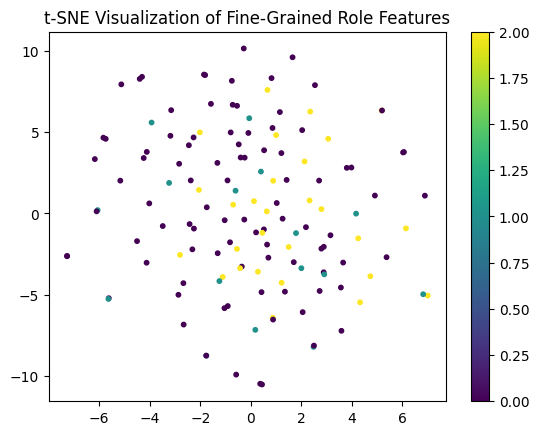


Random Forest Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
        Terro

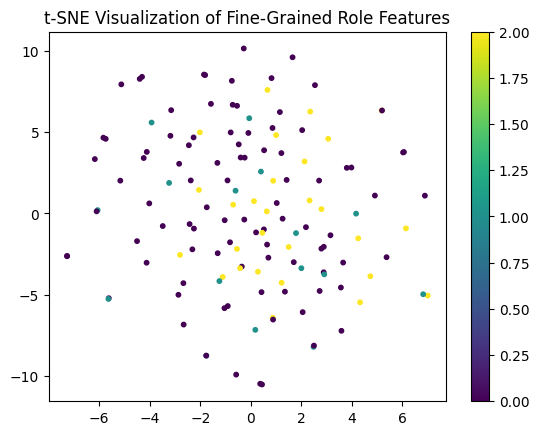


SVM Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
        Terrorist      

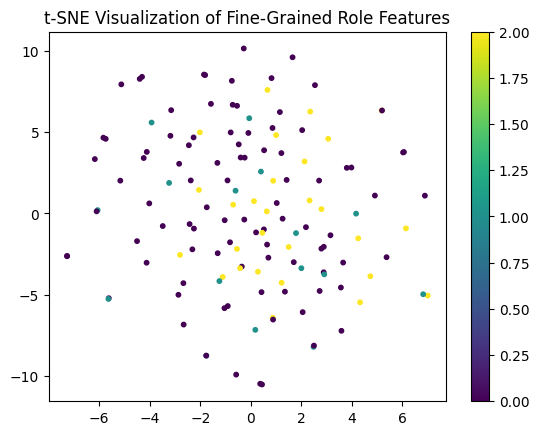


XGBoost Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
        Terrorist  

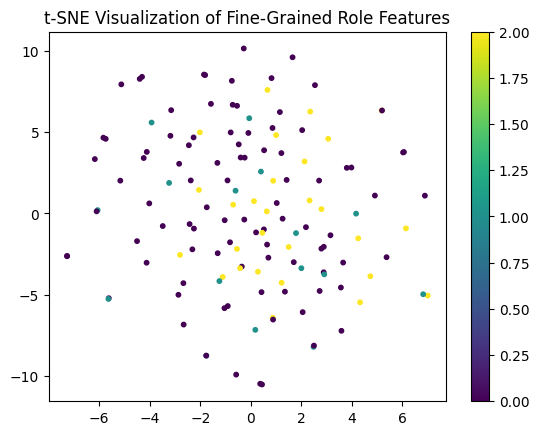


Logistic Regression Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
       

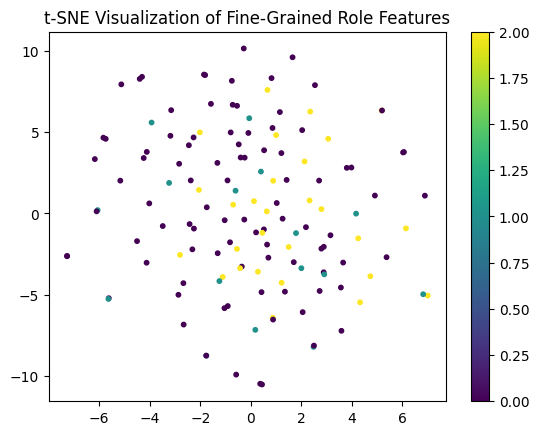


Neural Network Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
        Terr

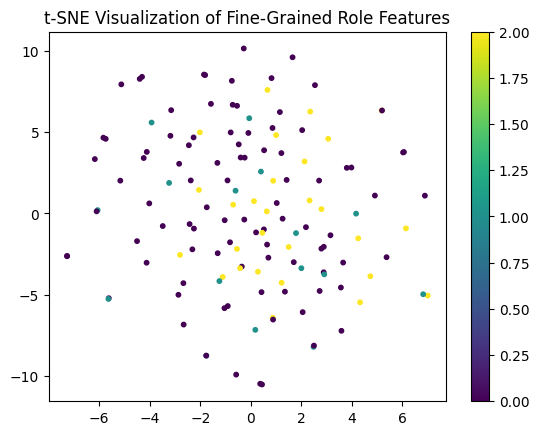


Extra Trees Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67         2
        Terrori

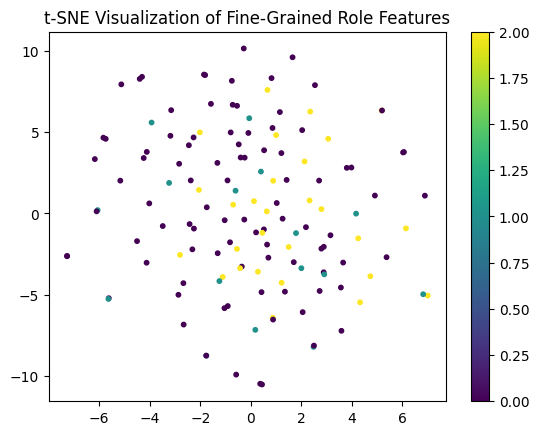


Multinomial Logistic Regression Fine-Grained Role Results:
                   precision    recall  f1-score   support

            Bigot       1.00      0.60      0.75         5
      Conspirator       1.00      0.83      0.91        12
          Corrupt       1.00      0.73      0.84        11
         Deceiver       1.00      0.71      0.83        14
        Exploited       1.00      0.67      0.80         3
Foreign Adversary       1.00      0.77      0.87        13
        Forgotten       1.00      1.00      1.00         1
         Guardian       1.00      0.67      0.80         9
      Incompetent       1.00      0.86      0.92        14
       Instigator       1.00      0.73      0.84        11
           Martyr       1.00      0.50      0.67         2
       Peacemaker       1.00      1.00      1.00         5
            Rebel       1.00      0.80      0.89         5
         Saboteur       1.00      1.00      1.00         2
        Scapegoat       1.00      0.50      0.67      

In [20]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE


# Evaluate Fine-Grained Classifiers for All Models
for model_name, result in fine_grained_results.items():
    mlb = MultiLabelBinarizer()
    y_true_binary = mlb.fit_transform(result['true_labels'])
    y_pred_binary = mlb.transform(result['predictions'])

    # cm = confusion_matrix(y_true_binary.argmax(axis=1), y_pred_binary.argmax(axis=1))
    # disp = ConfusionMatrixDisplay(cm, display_labels=mlb.classes_)
    # disp.plot(cmap="viridis")

    tsne = TSNE(n_components=2, random_state=40)
    X_embedded = tsne.fit_transform(X_test)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, cmap='viridis', s=10)
    plt.colorbar()
    plt.title("t-SNE Visualization of Fine-Grained Role Features")
    plt.show()



    print(f"\n{model_name} Fine-Grained Role Results:")

    # Debug missing predictions
    missing_labels = set(np.flatnonzero(y_true_binary.sum(axis=0))) - set(np.flatnonzero(y_pred_binary.sum(axis=0)))
    if missing_labels:
        print(f"Labels missing in predictions: {', '.join(mlb.classes_[list(missing_labels)])}")

    # Print classification report
    print(classification_report(y_true_binary, y_pred_binary, target_names=mlb.classes_, zero_division=0))
    print(f"Exact Match Accuracy: {result['exact_match_accuracy']:.4f}")
    print(f"Hamming Loss: {result['hamming_loss']:.4f}")
